In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

In [2]:
rng = Random.default_rng();

# graph parameters
n = 100
p = 0.9
eta = 0.1

# planted ranking
planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

# graph model
type = "MUN" 

if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

B = magnetic_incidence(meta_g)
L = B * B'

y = zeros(ComplexF64,n, 1)
batch = Int(ceil(0.02*n))
id = rand(rng, 1:n, batch)
y[id] = exp.(-im * planted_score[id] * π / (n - 1));

# linear system solution
q = 1
H_target = q*inv(L + q * I);

# MC runs
n_rep = 150

x = zeros(ComplexF64,n,1)
tau = zeros(n_rep,1)
err = zeros(n_rep,1)
pc_nodes_in_trees = zeros(n_rep,1)

x_target = H_target * y

H = zeros(ComplexF64,n,n)
for l in 1:n_rep
    mtsf = multi_type_spanning_forest(rng, meta_g, q; weighted=true)
    vectors,pc_nodes = cumulate_angles(mtsf)
    for v in vectors
        scalar = v' * y
        x += v * scalar[1]
    end
    err[l] = norm(x/l - x_target)/norm(x_target)
    score = -angular_score(x)
    p = ranking_from_score(score)
    tau[l] = corkendall(p,planted_ranking)
    pc_nodes_in_trees[l] = pc_nodes
end

x_full = q*inv(L + q * I)*y
score = -angular_score(x_full)
p = ranking_from_score(score)
tau_full = corkendall(p,planted_ranking)


1.0

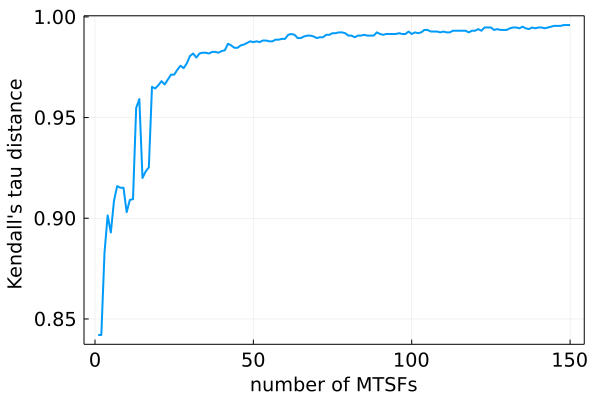

In [3]:
plot(1:n_rep,tau,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13), 
framestyle = :box,
margins = 0.1*2Plots.cm,
legend = false)
xlabel!("number of MTSFs")
ylabel!("Kendall's tau distance ")

In [39]:
tr(L*inv(L + q * I))

98.10903437720822 + 9.689941288742575e-17im

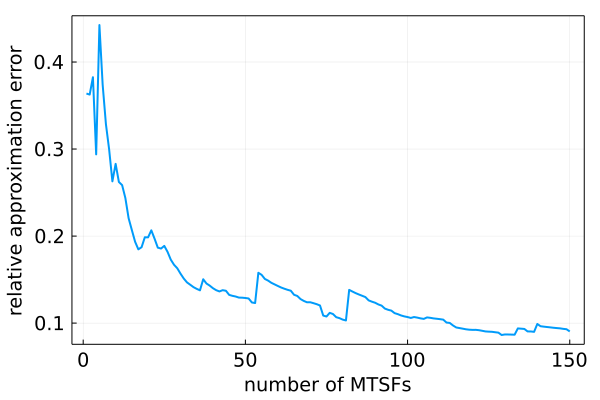

In [4]:
plot(1:n_rep,err,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13), 
legendfont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
legend = false)
ylabel!("relative approximation error")
xlabel!("number of MTSFs")
